In [189]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt

# Wstępne informacje

Zbiór składa się z 4 podzbiorów:
- ***QaTa-COV19-v1***:\
    Na zbiór ten składają się 4603 zdjęcia, z czego 2951 (64%) ma swoje maski.
- ***QaTa-COV19-v2***:\
    Zbiór ten podzielony został na część testową oraz treningową, łącznie składa się na niego 9258 zdjęć płuc. Co najważniejsze, każde zdjęcie w tym zbiorze ma przyporządkowaną maskę.
- ***Early-QaTa-COV19***:\
    Na zbiór ten składa się 1065 zdjęć. Na 801 przedstawiono płuca zdrowe, pozostałe 264 to płuca w ograniczonym stopniu zmienione przez COVID. W podzbiorze tym nie znajdują się żadne maski lub annotacje.
- ***Control_Group***:\
    Zbiór ten podzielony jest na 2 podzbiory. W pierwszym (Control_Group_I) znajduje się 12 544 zdjęć płuc zdrowych, natomiast w drugim (Control_Group_II) aż 116,365 zdjęć przedstawiających zarówno płuca zdrowe, jak i dotknięte różnymi schorzeniami. Niestety, w zbiorze tym brakuje jakichkolwiek annotacji lub masek.

Niestety, przez brak masek ostatnie dwa zbiory mają ograniczoną użyteczność dla zadania segmentacji, dlatego w dalszych analizach skupimy się tylko na podzbiorach ***QaTa-COV19-v1*** i ***QaTa-COV19-v2***. Pozostałe podzbiory, dzięki informacjom iż znajdują się w nich zdjęcia płuc zdrowych/ dotkniętych konkretną chorobą mogą okazać się przydatne później, jako np. dane dodatkowe dla zadania klasyfikacji.

# Analiza

Na samym początku warto zauważyć, że nasz zbiór nie posiada żadnych danych tabularycznych. W naszym zadaniu interesować nas będą przede wszystkim zdjęcia i przyporządkowane im maski- znajdźmy więc zdjęcia pozbawione masek (zdjęcia te mają ograniczoną użyteczność, gdyż nawet przy testowaniu nie otrzymamy informacji zwrotnej, czy maska została nałożona poprawnie)

### Zdjęcia pozbawione masek

In [112]:
path = 'Qata-COV19\QaTa-COV19-v1'

In [113]:
os.chdir(path)

In [114]:
images = os.listdir('Images')
gts = os.listdir('Ground-truths')

In [117]:
gts = [g.replace('mask_','') for g in gts]

In [118]:
masked = list(set(images).intersection(gts))

In [119]:
len(masked) == len(gts)

True

In [120]:
os.chdir('..')

In [121]:
gts = ["mask_" + g for g in gts]
for file in masked:
    name1 = "QaTa-COV19-v1\Images\\" + file
    name2 = "QaTa-COV19-v1\Images\\1_" + file
    os.rename(name1, name2)
for file in gts:
    name1 = "QaTa-COV19-v1\Ground-truths\\" + file
    name2 = "QaTa-COV19-v1\Ground-truths\\1_" + file
    os.rename(name1, name2)
masked = ["1_" + m for m in masked]
gts = ["1_" + g for g in gts]

Przerzućmy teraz wszystkie pliki z maskami do zbioru treningowego w ***QaTa-COV19-v2***. Od teraz będziemy pracować tylko na tym zbiorze.

In [122]:
for file in masked:
    name1 = "QaTa-COV19-v1\Images\\" + file
    name2 = "QaTa-COV19-v2\Train set\Images\\" + file
    os.rename(name1, name2)

In [123]:
for file in gts:
    name1 = "QaTa-COV19-v1\Ground-truths\\" + file
    name2 = "QaTa-COV19-v2\Train set\Ground-truths\\" + file
    os.rename(name1, name2)

In [124]:
#korekta nazw
path = "QaTa-COV19-v2\Train set\Ground-truths\\"
for file in os.listdir(path):
    name1 = path + file
    name2 = name1.replace("1_mask_", "mask_1_")
    os.rename(name1,name2)

### Ogólna charakterystyka i przykładowe zdjęcia

In [180]:
path = 'Qata-COV19-v2\Train Set\Images\\'
path_masks = 'Qata-COV19-v2\Train Set\Ground-truths\\'

In [181]:
def disp(file):
    im = Image.open(path + file)

    display(im.resize((im.size[0] * 2, im.size[1] * 2)))
def disp_mask(file):
    im = Image.open(path_masks + file)

    display(im.resize((im.size[0] * 2, im.size[1] * 2)))

Czym charakteryzuje się nasz zbiór danych? Niestety brak nam jakiegokolwiek opisu pacjentów- w bazie danych mamy jedynie zdjęcia i odpowiadające im maski- w związku z powyższym "rozeznanie" w danych ogranicza się do ich ogólnego przeglądu. Na jego podstawie łatwo stwierdzić, że w naszych danych dominują zdjęcia "na wprost", przodem lub tyłem do aparatu. Można jednak wskazać pewne anomalie, co zrobimy poniżej.

Przykładowe zdjęcia:

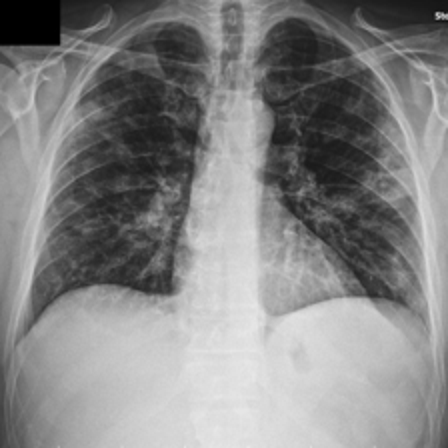

In [176]:
disp('covid_3841.png')

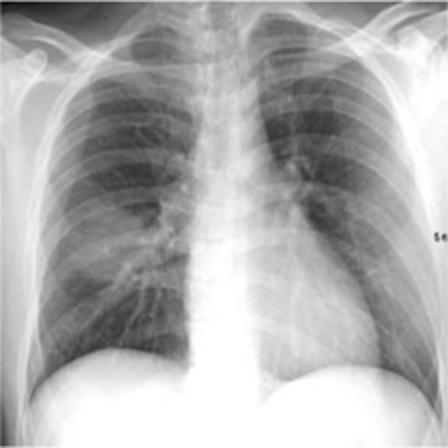

In [177]:
disp('covid_2568.png')

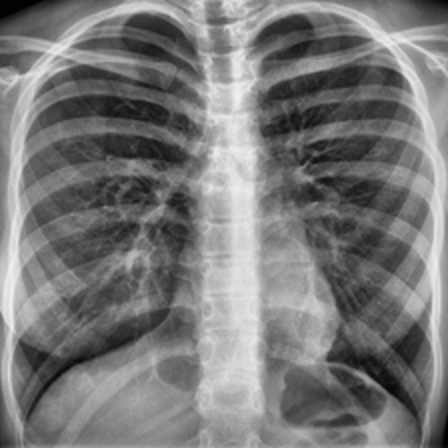

In [179]:
disp('covid_2797.png')

### Porównania rozmiarów

Zanim przejdziemy do zaprezentowania anomalii, sprawdzimy najpierw czy nasze obrazy różnią się znacząco rozmiarami.

In [221]:
def get_unique_sizes(path):
    imgs = os.listdir(path)
    widths = []
    heights = []
    for file in imgs:
        im = Image.open(path + file)
        w,h = np.array(im).shape
        widths.append(w)
        heights.append(h)
    print("Unique widths:{}".format(np.unique(widths)))
    print("Unique heights:{}".format(np.unique(heights)))

In [222]:
get_unique_sizes(path)

Unique widths:[224]
Unique heights:[224]


In [223]:
get_unique_sizes(path_masks)

Unique widths:[224]
Unique heights:[224]


Wszystkie zdjęcia mają ten sam rozmiar.

### Anomalie

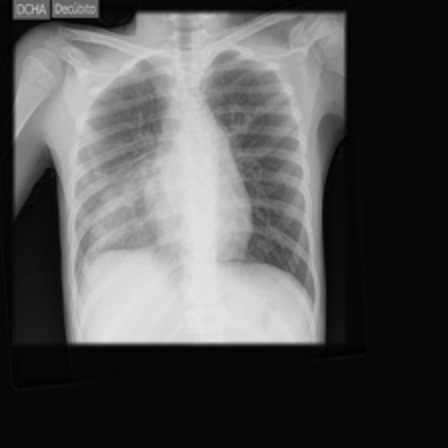

In [168]:
disp('1_covid_101.png')

Przykład "przesuniętego" zdjęcia.

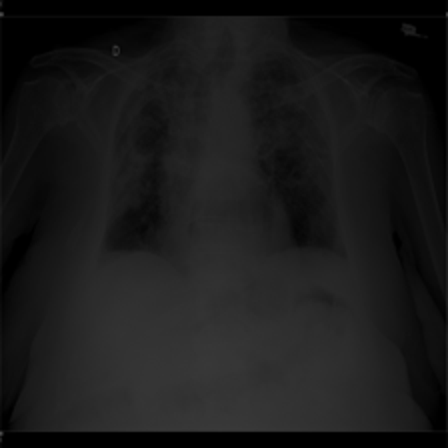

In [171]:
disp('1_covid_200.png')

Przykład "przyciemnionego" zdjęcia

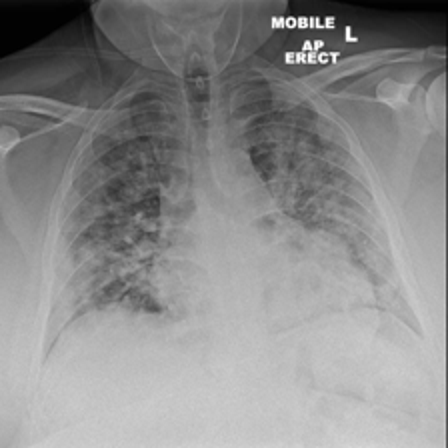

In [170]:
disp('1_covid_1113.png')

Napis na zdjęciu

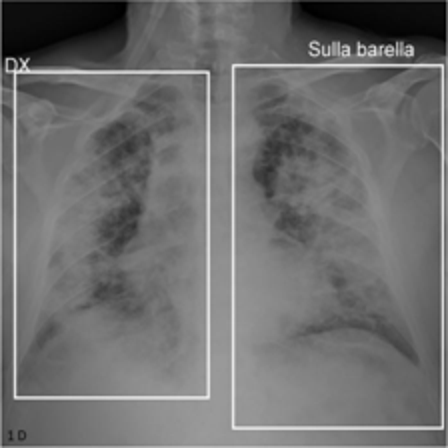

In [172]:
disp('1_covid_144.png')

Anotacje już nałożone na zdjęcie

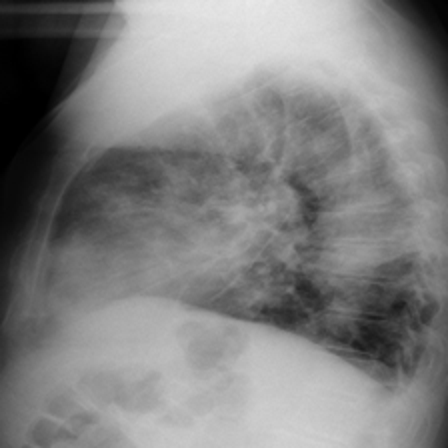

In [173]:
disp('1_covid_155.png')

Zdjęcie (prawdopodobnie) od boku

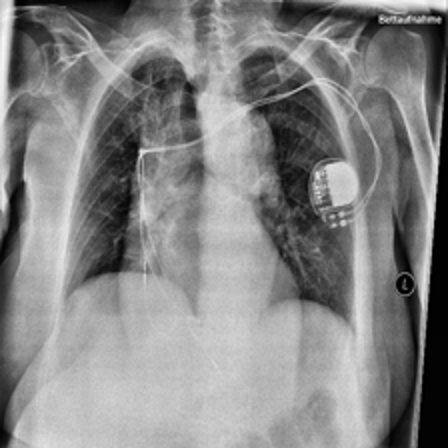

In [174]:
disp('1_covid_1305.png')

Aparatura medyczna na zdjęciu

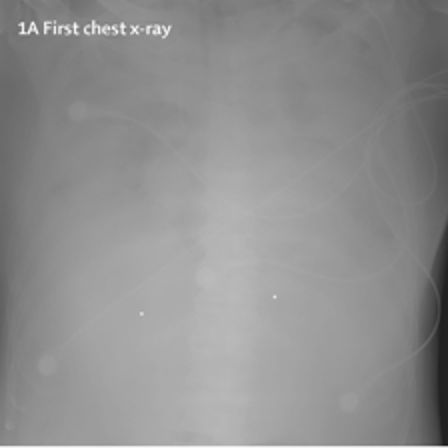

In [175]:
disp('covid_3897.png')

Zdjęcie niewyraźne

Powyżej przedstawiono najczęstsze "odstępstwa" od standardu danych, które mogą sprawiać problemy przy modelowaniu.

### Przykład nałożenia maski

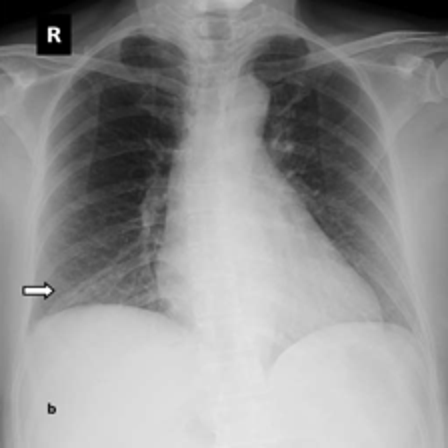

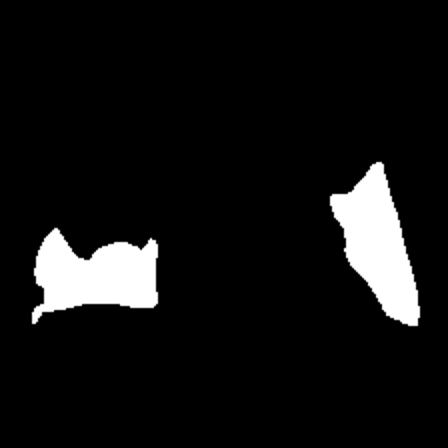

In [182]:
disp('1_covid_11.png')
disp_mask('mask_1_covid_11.png')

Przykład zdjęcia i odpowiadającej mu maski.

In [246]:
def draw_mask(file):
    im = Image.open(path + file)
    im_mask = Image.open(path_masks + 'mask_' + file)
    arr = np.array(im)
    arr_mask = np.array(im_mask)
    ones = []
    for i in range(arr_mask.shape[0]):
        for j in range(arr_mask.shape[1]):
            if arr_mask[i][j] != 0:
                ones.append((i,j))
    for one in ones:
        arr[one[0]][one[1]] = 255
    im1 = Image.fromarray(arr)
    display(im1.resize((im1.size[0] * 2, im1.size[1] * 2)))

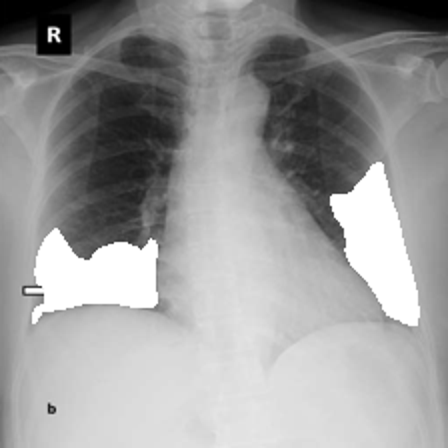

In [247]:
draw_mask('1_covid_11.png')

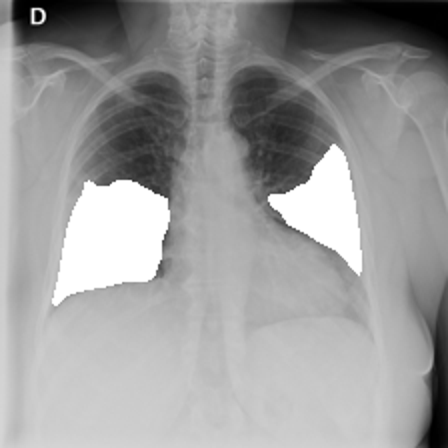

In [248]:
draw_mask('1_covid_76.png')

Zdjęcia z nałożonymi maskami

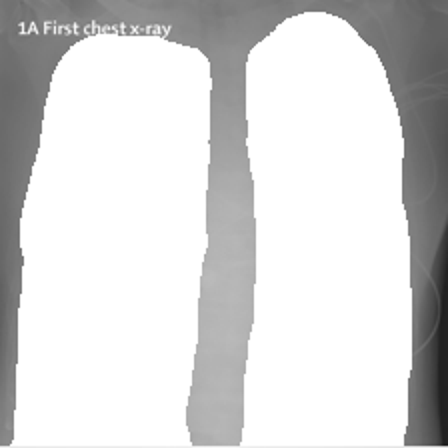

In [249]:
draw_mask('1_covid_3897.png')

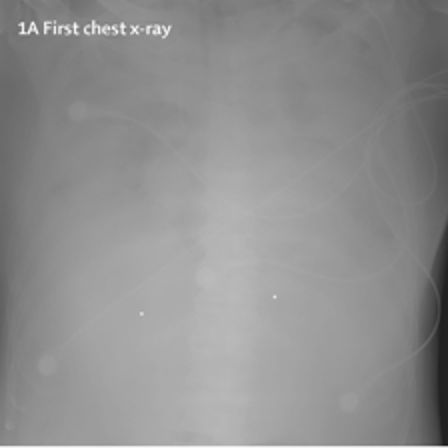

In [250]:
disp('1_covid_3897.png')

Przykład ciekawego pokrycia- czy jest to poprawna segmentacja?

# Wnioski

Zbiór danych, który skonstruowaliśmy ze wszystkich podzbiorów Qata-COV19 zawiera zdjęcia płuc osób chorych na COVID, wraz z maskami zaznaczającymi miejsca zmian chorobowych. Niestety, przez brak dokładniejszego opisu danych ciężko jest wyciągnąć wnioski głębsze niż "poglądowe"- wygląda jednak na to, że poza nielicznymi anomaliami zbiór jest dość regularny i dobrze skonstruowany- zdjęcia, choć czasem wykonane pod różnymi kątami, zdają się być zbliżone do siebie i wyraźnie przedstawiają zarysy płuc pacjentów. 

Na obecnym etapie rozdzieliłem zdjęcia posiadające maski od tych nieposiadających- tzn. też zdjęcia ze stwierdzoną infekcją od zdjęć "zdrowych" płuc- w przyszłości jednak jest możliwa ponowna integracja obu zbiorów.